# Интеллектуальный анализ данных – весна 2022

# Домашнее задание 7: Деревья. Случайный лес

Правила:

- Домашнее задание оценивается в 10 баллов (+1 бонусный балл).


- Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.


- Можно использовать любые свободные источники с обязательным указанием ссылки на них.


- Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

<!-- ![](meme.jpg) -->
<img src="meme.jpg" alt="Drawing" style="width: 700px;"/>

## Часть 1: Основы построения решающие дерева (1.5 балла)

В этой части все расчёты необходимо реализовывать в виде запрограммированных формул, например, на `numpy`. **Нельзя использовать готовые реализации**. Например, если в задании требуется рассчитать энтропию, то требуется в каком-то виде релизовать расчёт по формуле, но нельзя использовать готовую реализацию `some_module.entropy()`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Задание 1.1 (0.5 балла)** Пусть известно, что в вершину решающего дерева попали 10 объектов, 8 из которых имеют метку класса $k_1$, а 2 имеют метку класса $k_2$. Рассчитайте энтропию такого распределения классов (с натуральным логарифмом). Ответ округлите до двух знаков после запятой.

In [2]:
p = [0.8, 0.2]
H = round(-sum(i*np.log(i) for i in p), 2)
print('Энтропия равна', H)

Энтропия равна 0.5


**Задание 1.2 (0.5 балла)** Пусть дополнительно известно, что вершина из предыдущего задания не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса $k_1$, а в правое - класса $k_2$. Посчитайте критерий информативности:

$$
Q(R_m, j, t) = H(R_m) - \frac{|R_\ell|}{|R_m|}H(R_\ell) - \frac{|R_r|}{|R_m|}H(R_r),
$$

где $R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения, $R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

Теперь в качестве $H(R)$ будем использовать индекс Джини:

$$
H(R) = \sum_{k=1}^J p_k(1-p_k),
$$
где $J$ – общее количество классов (в нашем случае, $J = 2$).

Ответ округлите до двух знаков после запятой.

In [3]:
def jini(probs: list):
    return sum(p*(1-p) for p in probs)
Q = jini([0.8, 0.2]) - 0.8*jini([1, 0]) - 0.2*jini([0, 1])
print('Критерий информативности равен', Q)

Критерий информативности равен 0.32


**Задание 1.3 (0.5 балла)** Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] (решается задача регрессии). Чему будут равны предсказания модели для этих объектов?

In [4]:
def leaf_prediction_average(values: list):
    return np.average(values)
def leaf_prediction_median(values: list):
    return np.median(values)
val= [1, 10, 5, 18, 100, 30, 50, 61, 84, 47]
print('Предсказание модели, если значение в листе выбирается как\nСреднее: {}\nМедиана: {}'.format(leaf_prediction_average(val), leaf_prediction_median(val)))

Предсказание модели, если значение в листе выбирается как
Среднее: 40.6
Медиана: 38.5


## Часть 2: Решающие деревья (4.5 балла)

В этой части мы напишем и протестируем собственную реализацию решающего дерева.

In [5]:
from collections import Counter
from typing import Dict, List, Tuple, Union

**Задание 2.1 (1.5 балла)** Реализуйте функцию `find_best_split()`, которая должна находить оптимальное разбиение подмножества обучающей выборки в соответствии с информационным критерием из **Задания 1.2**. В качестве меры хаотичности $H(R)$ для задачи регрессии испольуйте дисперсию подвыборки, а для задачи классификации – критерий Джини (определён в том же задании).

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. Обратите внимание, что это далеко не оптимальные способ учёта категориальных признаков. Например, можно было бы на каждое значение категориального признака создавать отдельное поддерево или использовать более сложные подходы. Подробнее об этом можно прочитать в конспектах [лекций](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/lecture-notes/lecture07-trees.pdf) по машинному обучению на ПМИ (раздел «Учёт категориальных признаков»).

В качестве подсказок реализации можете пользоваться кодом из бонусной части семинара по решающим деревьям.

**Бонус:** Разрешается делать цикл для перебора порогов, но возможна имплементация без него. За имплементацию без цикла – **бонус 1 балл**.

In [6]:
def jini(probs: list):
    return sum(p*(1-p) for p in probs)

def variance(values:list):
    return np.var(values)

def split_node(features, targets, t, real=True):
    if real:
        mask = np.array([True if feature >= t else False for feature in features])
    else:
        mask = np.array([True if feature == t else False for feature in features])
    R_l = targets[mask]
    R_r = targets[mask==False]
    return (R_l, R_r)



def criteria_jini(R_l, R_r, targets):
    H_m = jini([sum(targets)/len(targets), (len(targets) - sum(targets))/len(targets)])
    H_l = jini([sum(R_l)/len(R_l), (1 - sum(R_l)/len(R_l))])
    H_r = jini([sum(R_r)/len(R_r), (1 - sum(R_r)/len(R_r))])
    Q = H_m - len(R_l)* H_l /len(targets) - len(R_r) * H_r / len(targets)
    return Q

def criteria_variance(R_l, R_r, targets):
    H_m = variance(targets)
    H_r = variance(R_r)
    H_l = variance(R_l)
    Q = H_m - len(R_l)* H_l /len(targets) - len(R_r) * H_r / len(targets)
    return Q


In [7]:
def find_best_split(
    feature_vector: Union[np.ndarray, pd.DataFrame], 
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    """
    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух сосдених (при сортировке) значений признака
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини или дисперсии нужно выбирать минимальный сплит.
    * За наличие в функции циклов балл будет снижен. Векторизуйте! :)

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  len(feature_vector) == len(target_vector)
    :param task: либо `classification`, либо `regression`
    :param feature_type: либо `real`, либо `categorical`
    
    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева
    :return ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return gini_best: оптимальное значение критерия Джини (число)
    """
    ginis = []
    thresholds = []
    if feature_type == "real":
        features_sorted = np.sort(feature_vector)
        for i in range(len(feature_vector)-1):
            t = np.mean((features_sorted[i], features_sorted[i+1]))
            R_l, R_s = split_node(feature_vector, target_vector, t)
            if len(R_l) * len(R_s) != 0: #and len(R_s) != 0:
                thresholds.append(t)
                if task == "classification":
                    ginis.append(criteria_jini(R_l, R_s, target_vector))
                elif task == "regression":
                    ginis.append(criteria_variance(R_l, R_s, target_vector))
    elif feature_type == 'categorical': #categorical features
        feature_unique = np.unique(feature_vector)
        for i in feature_unique:
            R_l, R_s = split_node(feature_vector, target_vector, i, real=False)
            if len(R_l) * len(R_s) != 0:
                thresholds.append(i)
                if task == 'classification':
                    ginis.append(criteria_jini(R_l, R_s, target_vector))
                elif task == 'regression':
                    ginis.append(criteria_variance(R_l, R_s, target_vector))
    if len(ginis) != 0:
        gini_best = max(ginis)
        threshold_best = thresholds[ginis.index(gini_best)]
    else: #эти значения не будут использоваться,  так как если в ginis не попало ни одного объекта, то это будет листовая вершина без разделения
        gini_best = -10
        threshold_best = '' 
    return (thresholds, ginis, threshold_best, gini_best)

Эту функцию можно протестировать на датасете `Boston` из `sklearn`.

In [8]:
from sklearn.datasets import load_boston

boston = load_boston()
X = pd.DataFrame(data=boston["data"], columns=boston["feature_names"])
y = boston["target"]
X.head()

# print(boston["DESCR"])

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [9]:
thresholds, variances, threshold_best, variance_best = find_best_split(
    X["CRIM"].to_numpy(), 
    y, 
    task="regression",
    feature_type="real"
)

Выведите график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `CRIM`.

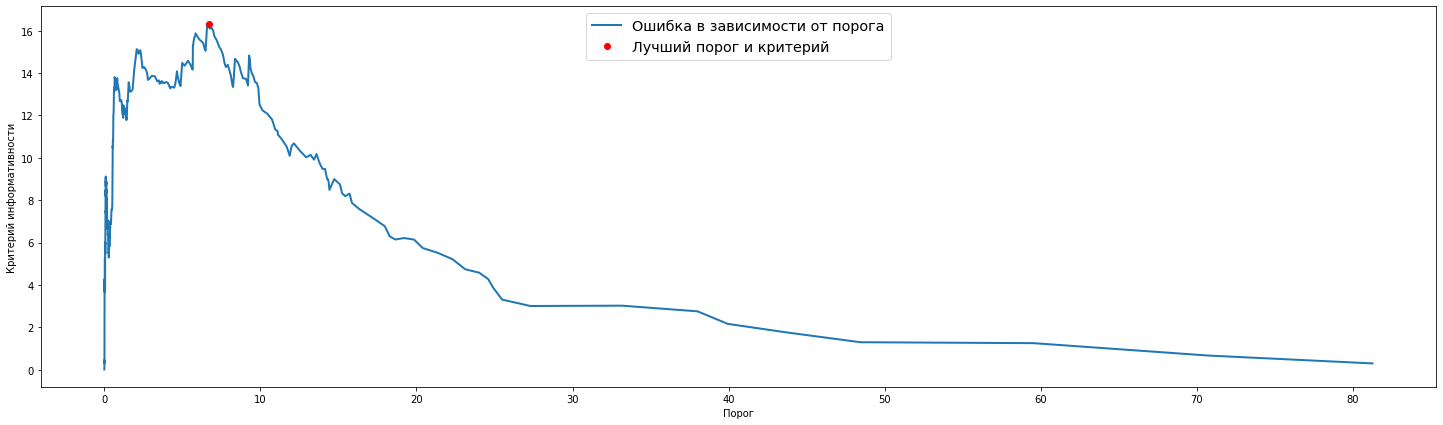

In [12]:
plt.figure(figsize=[25, 7])
plt.plot(thresholds, variances, linewidth=2)
# plt.axline([threshold_best, 0], [threshold_best, variance_best], color='y', marker='o')
# plt.axvline(x=threshold_best, color='y', marker='o')
# plt.axhline(y=variance_best, color='y', marker='o')
plt.plot(threshold_best, variance_best, 'ro')
plt.legend(['Ошибка в зависимости от порога', 'Лучший порог и критерий'], loc='upper center', fontsize='x-large')
plt.ylabel('Критерий информативности')
plt.xlabel('Порог')
plt.show()

**Задание 2.2 (1 балл)** Разберитесь с написанным кодом решающего дерева, заполните пропуски в коде и реализуйте недостающий метод `_predict_node()`.

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции в разделе «Построение дерева».
- **Выбор лучшего разбиения** необходимо производить по критерию Джини.
- **Критерий останова:** все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку.
- **Ответ в листе:** наиболее часто встречающийся класс в листе.

In [13]:
class DecisionTree:
    
    def __init__(
        self, 
        feature_types: Union[List[str], np.ndarray], 
        max_depth: int = None, 
        min_samples_split: int = None, 
        min_samples_leaf: int = None,
        task: str = "classification"
    ) -> None:
        
        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        # В этой переменной будем хранить узлы решающего дерева. Каждая вершина хранит в себе идентификатор того,
        # является ли она листовой. Листовые вершины хранят значение класса для предсказания, нелистовые - правого и
        # левого детей (поддеревья для продолжения процедуры предсказания)
        self._tree = {}
        
        # типы признаков (категориальные или числовые)
        self._feature_types = feature_types
        
        # гиперпараметры дерева
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task

    def _fit_node(
        self, 
        sub_X: np.ndarray, 
        sub_y: np.ndarray, 
        node: dict
    ) -> None:
        
        # критерий останова
        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]
            categories_map = {}

            # подготавливаем признак для поиска оптимального порога
            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                # здесь могла быть реализация более сложного подхода к обработке категориального признака
                feature_vector = sub_X[:, feature]

            # ищем оптимальный порог
            _, _, threshold, gini = find_best_split(feature_vector, sub_y, self.task, feature_type)
            
            if gini_best is None or gini > gini_best:
                feature_best = feature
                gini_best = gini

                # split - маска на объекты, которые должны попасть в левое поддерево
                if feature_type == "real":
                    threshold_best = threshold
                    split = feature_vector >= threshold_best
                elif feature_type == "categorical":
                    # в данной реализации это просто значение категории
                    threshold_best = threshold
                    split = feature_vector == threshold_best
                else:
                    raise ValueError

        # записываем полученные сплиты в атрибуты класса
        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        node["type"] = "nonterminal"

        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["category_split"] = threshold_best
        else:
            raise ValueError
            
        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"])

    def _predict_node(self, x: np.ndarray, node: dict) -> int:
        """
        Предсказание начинается с корневой вершины дерева и рекурсивно идёт в левое или правое поддерево в зависимости от значения
        предиката на объекте. Листовая вершина возвращает предсказание.
        :param x: np.array, элемент выборки
        :param node: dict, вершина дерева
        """
        # ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————-
        if node['type'] == 'nonterminal':
            feature = node['feature_split']
            if self._feature_types[feature] == 'real':
                if x[feature] >= node['threshold']:
                    return self._predict_node(x, node['left_child']) 
                else:
                    return self._predict_node(x, node['right_child'])
            elif self._feature_types[feature] == 'categorical':
                if x[feature] == node['category_split']:
                    return self._predict_node(x, node['left_child'])
                else:
                    return self._predict_node(x, node['right_child'])
        elif node['type'] == 'terminal':
            return node['class']
        

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self._fit_node(X, y, self._tree)

    def predict(self, X: np.ndarray) -> np.ndarray:
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))
            
        return np.array(predicted)

**Задание 2.3 (1 балл)** Загрузите таблицу [students.csv](https://drive.google.com/file/d/0B2zoFVYw1rN3a0d0Zm43TzQ4aUU/view?usp=sharing) (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте диаграммы рассеяния "значение признака — класс" для всех пяти признаков.

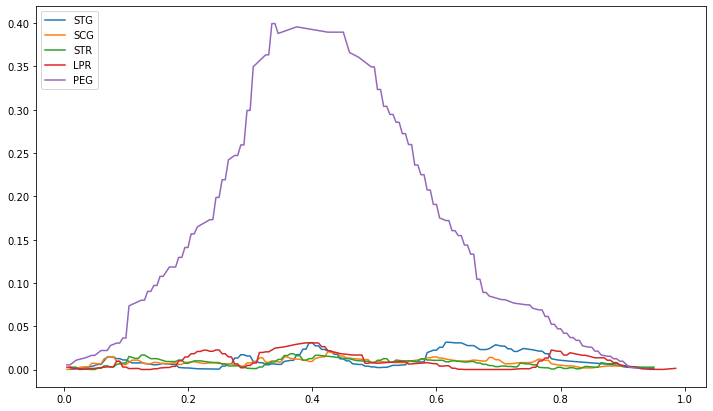

In [15]:
data = pd.read_csv('students.csv')
features = data.columns[0:5]
target = data.columns[-1]
plt.figure(figsize=[12,7])
for feature in features:
    thresholds, ginis, _, _ = find_best_split(
    data[feature].to_numpy(), 
    data[target].to_numpy(), 
    task="classification",
    feature_type="real"
)
    plt.plot(thresholds, ginis)
plt.legend(features, loc='upper left', fontsize='medium')
plt.show()

In [32]:
colours = ['olive', 'lightseagreen', 'darksalmon', 'slateblue', 'maroon']

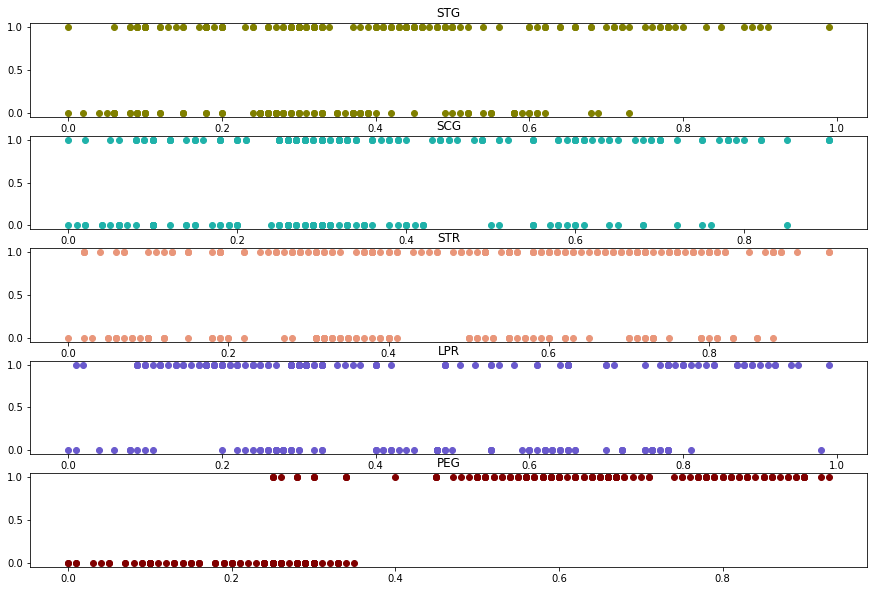

In [14]:
f, axes = plt.subplots(5,1, figsize=(15,10))
for feature, ax, col in zip(features, axes.flat, colours):
    ax.scatter(data[feature], data[target], c=col)
    ax.set_title(feature)

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой диаграмм рассеяиния? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

### Ответ
Разделение выборки на два поддерева однозначно нужно проводить по признаку PEG, и это согласуется с данными из диаграмм рассеяния. На этом признаке сразу виден примерный порог, который поделит нашу выборку почти безошибочно, тогда как на всех остальных признаках объекты обоих классов распределены более менее равномерно по всем значениям признака, и провести хорошее деление невозможно.

Кривая для "хороших" признаков будет похожа на функцию плотности для нормального распределения, тогда как кривые признаков, деление по которым почти невозможно, будут близки к прямым, колеблющимся около нуля.

**Задание 2.4 (1 балл)** Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). 

1. Скачайте таблицу `agaricus-lepiota.data` (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)), 
2. Считайте таблицу при помощи `pandas`,
3. Примените к каждому столбцу `LabelEncoder` (из `sklearn`), чтобы преобразовать строковые имена категорий в натуральные числа. 

Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

In [16]:
mushrooms = pd.read_csv('agaricus-lepiota.data')
for col in mushrooms.columns:
    mushrooms[col]  = LabelEncoder().fit_transform(mushrooms[col])
# X = mushrooms[mushrooms.columns[1:]]
X = mushrooms.iloc[:, 1:]
y = mushrooms.iloc[:, 0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

In [17]:
tree = DecisionTree(feature_types = ['categorical']*len(X.columns))
tree.fit(X_train.values, y_train.to_numpy())

In [18]:
predicted = tree.predict(X_test.values)
print('Accuracy решающего дерева: ', accuracy_score(predicted, y_test))

1.0

## Часть 3: Бэггинг и случайный лес (4 балла)

В данной части мы будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [3]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier

In [4]:
data = pd.read_csv('diabetes.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Посмотрим на распределение целевой переменной

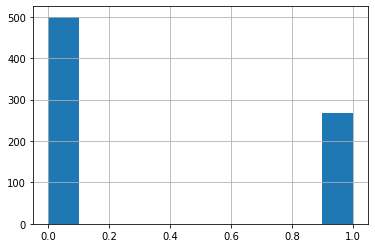

In [5]:
data['Outcome'].hist()
plt.show()

**Задание 3.1 (0.5 балла)** Разделите данные на признаки и целевую переменную. Разбейте датасет на обучающую и тестовую части в отношении 7:3. Затем разделите обучающую выборку на обучающую-обучающую и обучающую-валидационную в соотношении 7:3 (то есть в итоге должно получиться три выборки: обучающая-обучающая (0.49 от исходного датасета), обучающая-валидационная (0.21 от исходного датасета) и тестовая (0.3 от исходного датасета).

In [6]:
X_fulltrain, X_test, y_fulltrain, y_test = train_test_split(data.iloc[:, :-1], data.iloc[:, -1], test_size = 0.3, random_state=12)
X_train, X_val, y_train, y_val = train_test_split(X_fulltrain, y_fulltrain, test_size = 0.3, random_state=12)

**Задание 3.2 (1 балл)** На обучающей-валидационной выборке подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_leaf` для `DecisionTreeClassifier`. Для этого:
1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений обучите дерево на обучающей-обучающей выборке и определите качество на обучающей-валидационной выборке. В качестве критерия будем использовать `f1-меру`.
3. Выберите ту пару значений, которая даёт наилучшее качество на обучающей-валидационной выборке. 


Обучите решающее дерево с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

In [7]:
depths = [2, 4, 5, 6, 8, 10]
leafs = [1, 3, 5, 7, 9]
history = []
for depth in depths:
    for leaf in leafs:
        tree = DecisionTreeClassifier(max_depth = depth, min_samples_leaf=leaf, random_state=18)
        tree.fit(X_train, y_train)
        predicted = tree.predict(X_val)
        history.append([depth, leaf, round(f1_score(predicted, y_val), 3)])
df = pd.DataFrame(history, columns =['Глубина', 'Мин. элементов в листе', 'F-1 мера'])
df.sort_values('F-1 мера', ascending=False).head()

,Глубина,Мин. элементов в листе,F-1 мера
8,4,7,0.632
5,4,1,0.627
18,6,7,0.625
28,10,7,0.621
7,4,5,0.621


In [8]:
tree = DecisionTreeClassifier(max_depth = 4, min_samples_leaf=7, random_state=18)
tree.fit(X_fulltrain, y_fulltrain)
predicted = tree.predict(X_test)
print('Решающее дерево:\n')
print(f'Accuracy:\t{accuracy_score(y_test, predicted)}\nPrecision:\t{precision_score(y_test, predicted)}\nRecall:\t\t{recall_score(y_test, predicted)}\nAUC-ROC:\t{roc_auc_score(y_test, predicted)}')
print(f'F-1 score:\t{f1_score(y_test, predicted)}')

Решающее дерево:

Accuracy:	0.7662337662337663
Precision:	0.6744186046511628
Recall:		0.6904761904761905
AUC-ROC:	0.75
F-1 score:	0.6823529411764705


**Задание 3.3 (0.5 балла)** Обучите [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по тем же метрикам.

In [9]:
bagcls = BaggingClassifier(n_estimators=50, random_state=25).fit(X_fulltrain, y_fulltrain)
predicted = bagcls.predict(X_test)
print('Бэггинг:\n')
print(f'Accuracy:\t{accuracy_score(y_test, predicted)}\nPrecision:\t{precision_score(y_test, predicted)}\nRecall:\t\t{recall_score(y_test, predicted)}\nAUC-ROC:\t{roc_auc_score(y_test, predicted)}')
print(f'F-1 score:\t{f1_score(y_test, predicted)}')

Бэггинг:

Accuracy:	0.7619047619047619
Precision:	0.6986301369863014
Recall:		0.6071428571428571
AUC-ROC:	0.7287414965986395
F-1 score:	0.6496815286624203


**Задание 3.4 (1 балл)** Выполните кросс-валидацию на полной обучающей выборке и подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_split` для `Random Forest` с 50 деревьями. Для этого:

1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений проведите кросс-валидацию на полной обучающей выборке. Количество разбиений выберите на ваш вкус. В качестве критерия будем использовать `f1-меру`. Усредните значение критерия по всем прогонам кросс-валидации. 
3. Выберите ту пару значений, которая даёт наилучшее среднее качество. 

Обучите случайный лес с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации по тем же метрикам. Какая из трёх построенных моделей показала себя лучше?

In [10]:
history = []
depths = [2, 4, 5, 6, 8, 10]
splits = [2, 4, 5, 7, 9]
for depth in depths:
    for split in splits:
        clf = RandomForestClassifier(max_depth=depth, min_samples_split=split, random_state = 25)
        f1 = np.mean(cross_val_score(clf, X_fulltrain, y_fulltrain, scoring="f1", cv=7))
        history.append([depth, split, f1])
df = pd.DataFrame(history, columns =['Глубина', 'Мин. сплит', 'F-1 мера'])
df.sort_values('F-1 мера', ascending=False).head()

,Глубина,Мин. сплит,F-1 мера
21,8,4,0.619913
28,10,7,0.612891
22,8,5,0.609067
25,10,2,0.608849
27,10,5,0.606062


In [11]:
forest_clf =  RandomForestClassifier(max_depth=8, min_samples_split=4, random_state = 25).fit(X_fulltrain, y_fulltrain)
predicted = forest_clf.predict(X_test)
print('Случайный лес:\n')
print(f'Accuracy:\t{accuracy_score(y_test, predicted)}\nPrecision:\t{precision_score(y_test, predicted)}\nRecall:\t\t{recall_score(y_test, predicted)}\nAUC-ROC:\t{roc_auc_score(y_test, predicted)}')
print(f'F-1 score:\t{f1_score(y_test, predicted)}')

Случайный лес:

Accuracy:	0.7965367965367965
Precision:	0.7681159420289855
Recall:		0.6309523809523809
AUC-ROC:	0.7610544217687075
F-1 score:	0.6928104575163399


#### Лучший результат показал Случайный лес. Хотя, конечно, значения метрик сильно зависят от random_state.

**Задание 3.5 (0.5 балла)** Постройте график зависимости AUC ROC на тестовой выборке от числа деревьев (`n_estimators`) для случайного леса, обучаемого на **полной обучающей** выборке. Какие выводы можно сделать?

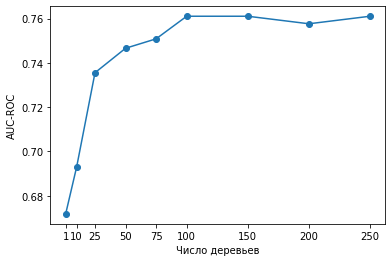

In [29]:
estimators = [1, 10, 25, 50, 75, 100, 150, 200, 250]
aucs = []
for n in estimators:
    forest =  RandomForestClassifier(n_estimators=n, max_depth=8, min_samples_split=4, random_state = 25).fit(X_fulltrain, y_fulltrain)
    predicted = forest.predict(X_test)
    aucs.append(roc_auc_score(y_test, predicted))
plt.plot(estimators, aucs, marker='o')
plt.xlabel('Число деревьев')
plt.ylabel('AUC-ROC')
plt.xticks(estimators)
plt.show()

#### Выводы
Дефолтное значение n_estimators=100 в RandomForestClassifier стоит там оправданно, на нем AUC-ROC максимальный :)

А вообще видно, что довольно быстро (начиная где-то с 75-100 базовых деревьев) случайный лес доходит до некоторого значения AUC-ROC, на котором остается +- стабильно даже при сильном увеличении количества числа базовых деревьев:

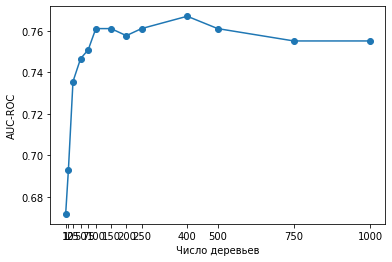

In [97]:
estimators.extend((400, 500, 750, 1000))
extended = [400, 500, 750, 1000]
for n in extended:
    forest =  RandomForestClassifier(n_estimators=n, max_depth=8, min_samples_split=4, random_state = 25).fit(X_fulltrain, y_fulltrain)
    predicted = forest.predict(X_test)
    aucs.append(roc_auc_score(y_test, predicted))
plt.plot(estimators, aucs, marker='o')
plt.xlabel('Число деревьев')
plt.ylabel('AUC-ROC')
plt.xticks(estimators)
plt.show()

**Задание 3.6 (0.5 балла)** Для лучшей модели случайного леса из **Задания 3.4** посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?

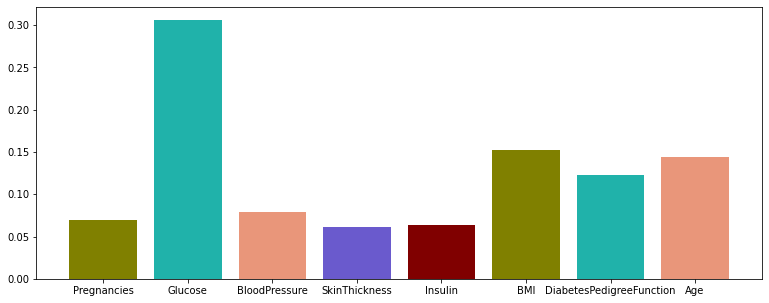

In [33]:
importances = forest_clf.feature_importances_
names = X_fulltrain.columns.tolist()
plt.figure(figsize=(13,5))
plt.bar(names, importances, color=colours)
plt.show()

##### выводы
основным признаком, по которому определяется наличие диабета - уровень глюкозы в крови